In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.metrics import make_scorer, roc_auc_score,confusion_matrix
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay,roc_curve
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold,StratifiedKFold
import math
import csv
import torch

#The model
from sklearn.svm import OneClassSVM


#For preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler

#serialization
import pickle

# from tqdm import tqdm
from tqdm.notebook import tqdm
import warnings
warnings.simplefilter("ignore")

In [16]:
class AnomalyDetectionDataLoader:

    def __init__(self, file_path, test_size=0.15, random_state=42):
        self.file_path = file_path
        self.test_size = test_size
        self.random_state = random_state
        self.data = None
        self.target = None
        self.xtrain = None
        self.xtest = None
        self.ytrain = None
        self.ytest = None
        self.scaler = MinMaxScaler()

    def load_data(self):
        # Charger les données depuis le fichier CSV
        self.data = pd.read_csv(self.file_path)

        # Supprimer les duplicatas en conservant la dernière occurrence
        self.data.drop_duplicates(keep="last", inplace=True)

        # Extraire la variable cible et les caractéristiques
        self.target = self.data["Class"]
        self.data = self.data.drop(["Class", "Time"], axis=1)

    def preprocess_data(self):
        # Normaliser les caractéristiques avec Min-Max Scaling
        data_scaled_array = self.scaler.fit_transform(self.data)
        self.data = pd.DataFrame(data_scaled_array, columns=self.data.columns)

    def split_data(self):
        # Diviser les données en ensembles d'entraînement et de test
        self.xtrain, self.xtest, self.ytrain, self.ytest = train_test_split(
            self.data, self.target, test_size=self.test_size, random_state=self.random_state, shuffle=True)

    def get_train_data(self):
        return self.xtrain, self.ytrain

    def get_test_data(self):
        return self.xtest, self.ytest

    def get_scaler(self):
        return self.scaler



In [17]:
def transform_target(target):
    """Args:
        target: np.ndarry or pd.DataFrame
    """
    n=target.shape[0]
    if isinstance(target,np.ndarray):
        target[target==1]=-1
        target[target==0]=1

    elif isinstance(target,pd.DataFrame) or isinstance(target,pd.Series):
        target[target==1]=-1
        target[target==0]=1
    return target


def inverse_transform_target(target):
    n=target.shape[0]
    if isinstance(target,pd.DataFrame) or isinstance(target,pd.Series):
        target[target==1]=0
        target[target==-1]=1

    elif isinstance(target,np.ndarray):
        target[target==1]=0
        target[target==-1]=1
    return target

In [41]:
def confusin_matrix_display(ytest,ypred):
    metrics.ConfusionMatrixDisplay(confusion_matrix(ytest,ypred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

def precision_recall_display(ytest, ypred):
    precision, recall, _ = precision_recall_curve(ytest, ypred)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()
    plt.title("Precision_Recall_Curve")
    plt.show()

def roc_curve_disolay(ytest, ypred):
    fpr, tpr, thresholds = metrics.roc_curve(ytest, ypred)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    print(f"roc_auc {roc_auc}")
    display.plot()
    plt.title("ROC_Curve")
    plt.show()

def scores_(ytest,ypred):
    df=pd.DataFrame({"f1_score" : [f1_score(ytest,ypred)],
                     "accuracy_score" : [accuracy_score(ytest,ypred)],
                     "precision_score" : [precision_score(ytest,ypred)],
                     "recall_score" : [recall_score(ytest,ypred)]
    })
    print(df)
    return df
def draw_anomaly(y_true,score, seuil):
    groupDF=pd.DataFrame({
        "error":score,
        "true":y_true
    }).groupby('true')
    fig, ax=plt.subplots(figsize=(12,8))

    for name, group in groupDF:
        ax.plot(group.index,group.error,marker='x', linestyle='',color='r' if name==1 else 'g',label="anomalie" if name==1 else "normal")
    ax.hlines(seuil,ax.get_xlim()[0],ax.get_xlim()[1], colors ="b", zorder=100,label="Seuil")
    ax.legend()
    
    plt.title("Anomalies")
    plt.xlabel("Données")
    plt.ylabel("Score(erreur)")
    plt.show()
    
def evaluation(ytrue,ypred):
    confusin_matrix_display(ytrue,ypred)
    # precision_recall_display(ytrue, ypred)
    # roc_curve_disolay(ytrue, ypred)
    scores_(ytrue,ypred)

In [19]:
class CustomGridSearchCV:

    def __init__(self, estimator, param_grid, n_splits=5, random_state=42):
        self.estimator = estimator
        self.param_grid = param_grid
        self.n_splits = n_splits
        self.random_state = random_state
        self.best_score = 0
        self.best_params = None
        self.best_estimator = None

    def fit(self, X, y):


        param_grid = ParameterGrid(self.param_grid)
        skf=StratifiedKFold(n_splits=self.n_splits, random_state=None, shuffle=False)

        for params in tqdm(param_grid):


            total_score = 0

            # Itérer sur les plis de la validation croisée
            for train_index, val_index in tqdm(skf.split(X,y)):
                xtrain_fold, xval_fold = X.iloc[train_index], X.iloc[val_index]
                ytrain_fold, yval_fold = y.iloc[train_index], y.iloc[val_index]

                # Entraîner le modèle
                model = self.estimator.set_params(**params)
                model.fit(xtrain_fold)

                # Faire des prédictions
                ypred_val = model.predict(xval_fold)
                ypred_val = inverse_transform_target(ypred_val)

                current_score = f1_score(ypred_val, yval_fold)

                total_score += current_score

            avg_score = total_score / self.n_splits

            # Afficher les paramètres et le score moyen
            print("Paramètres:", params)
            print("Score moyen (f1_score):", avg_score)
            print(" ")

            if avg_score > self.best_score:
                self.best_score = avg_score
                self.best_params = params
                self.best_estimator=model

        # Afficher les meilleurs paramètres
        print("Meilleurs paramètres :", self.best_params)
        print("Meilleur score moyen (f1_score) :", self.best_score)
    def predict(self,xtest):
        return self.best_estimator.fit_predict(xtest)

In [20]:
# Utilisation de la classe
data_loader = AnomalyDetectionDataLoader(file_path="/home/dah/anomalie_detection/anomalie_detection/data/creditcard.csv")
data_loader.load_data()
data_loader.preprocess_data()
data_loader.split_data()

xtrain, ytrain = data_loader.get_train_data()
xtest, ytest = data_loader.get_test_data()
scaler = data_loader.get_scaler()


In [21]:
params={'kernel': 'poly', 'nu': 0.0026,'gamma':'auto','degree':9}

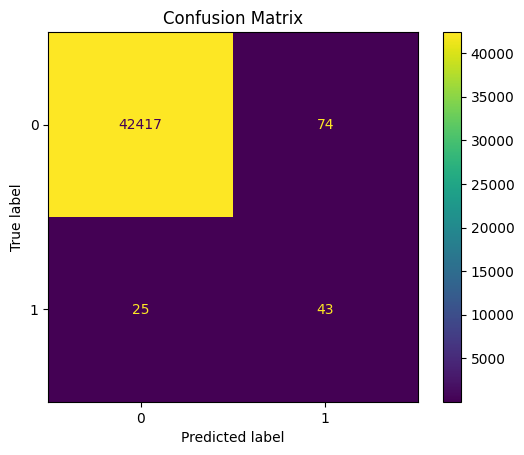

   f1_score  accuracy_score  precision_score  recall_score
0  0.464865        0.997674         0.367521      0.632353


In [22]:
params={'kernel': 'poly', 'nu': 0.0026,'gamma':'auto','degree':9}
clf=OneClassSVM(**params)
clf.fit(xtrain)

ypred=clf.predict(xtest)
ypred=inverse_transform_target(ypred)
evaluation(ytest,ypred)

In [23]:
ypred=clf.predict(xtest)

In [24]:
ypred=inverse_transform_target(ypred)

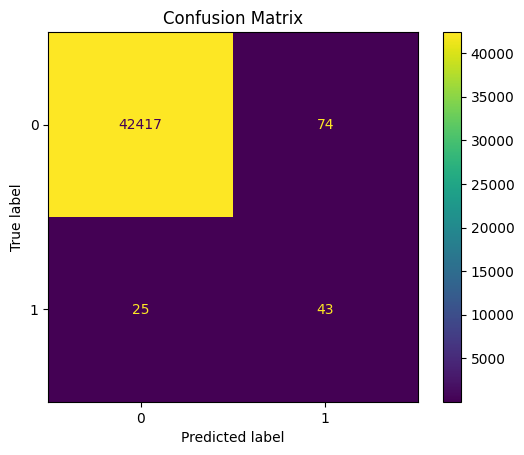

   f1_score  accuracy_score  precision_score  recall_score
0  0.464865        0.997674         0.367521      0.632353


In [25]:
evaluation(ytest,ypred)

In [26]:
best_par={
          'kernel': ["sigmoid","poly","rbf"],
          'nu': [0.001,0.002,0.0026,0.003], #0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
          'degree':[1,2,3,4,5,6,7,8,9,10]
}
model=CustomGridSearchCV(estimator=OneClassSVM(gamma='auto'), param_grid=best_par, n_splits=5, random_state=42)
model.fit(xtrain,ytrain)

  0%|          | 0/120 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Paramètres: {'degree': 1, 'kernel': 'sigmoid', 'nu': 0.001}
Score moyen (f1_score): 0.3803616242847473
 


0it [00:00, ?it/s]

Paramètres: {'degree': 1, 'kernel': 'sigmoid', 'nu': 0.002}
Score moyen (f1_score): 0.42897657390971167
 


0it [00:00, ?it/s]

Paramètres: {'degree': 1, 'kernel': 'sigmoid', 'nu': 0.0026}
Score moyen (f1_score): 0.4142263033900077
 


0it [00:00, ?it/s]

Paramètres: {'degree': 1, 'kernel': 'sigmoid', 'nu': 0.003}
Score moyen (f1_score): 0.4013564454643742
 


0it [00:00, ?it/s]

Paramètres: {'degree': 1, 'kernel': 'poly', 'nu': 0.001}
Score moyen (f1_score): 0.3803616242847473
 


0it [00:00, ?it/s]

Paramètres: {'degree': 1, 'kernel': 'poly', 'nu': 0.002}
Score moyen (f1_score): 0.43119999549986987
 


0it [00:00, ?it/s]

Paramètres: {'degree': 1, 'kernel': 'poly', 'nu': 0.0026}
Score moyen (f1_score): 0.41570175720383223
 


0it [00:00, ?it/s]

Paramètres: {'degree': 1, 'kernel': 'poly', 'nu': 0.003}
Score moyen (f1_score): 0.4013564454643742
 


0it [00:00, ?it/s]

Paramètres: {'degree': 1, 'kernel': 'rbf', 'nu': 0.001}
Score moyen (f1_score): 0.20757837431385817
 


0it [00:00, ?it/s]

Paramètres: {'degree': 1, 'kernel': 'rbf', 'nu': 0.002}
Score moyen (f1_score): 0.2528559421587907
 


0it [00:00, ?it/s]

Paramètres: {'degree': 1, 'kernel': 'rbf', 'nu': 0.0026}
Score moyen (f1_score): 0.26651083267463666
 


0it [00:00, ?it/s]

Paramètres: {'degree': 1, 'kernel': 'rbf', 'nu': 0.003}
Score moyen (f1_score): 0.2587716838455337
 


0it [00:00, ?it/s]

Paramètres: {'degree': 2, 'kernel': 'sigmoid', 'nu': 0.001}
Score moyen (f1_score): 0.3803616242847473
 


0it [00:00, ?it/s]

Paramètres: {'degree': 2, 'kernel': 'sigmoid', 'nu': 0.002}
Score moyen (f1_score): 0.42897657390971167
 


0it [00:00, ?it/s]

Paramètres: {'degree': 2, 'kernel': 'sigmoid', 'nu': 0.0026}
Score moyen (f1_score): 0.4142263033900077
 


0it [00:00, ?it/s]

Paramètres: {'degree': 2, 'kernel': 'sigmoid', 'nu': 0.003}
Score moyen (f1_score): 0.4013564454643742
 


0it [00:00, ?it/s]

Paramètres: {'degree': 2, 'kernel': 'poly', 'nu': 0.001}
Score moyen (f1_score): 0.3868142968142968
 


0it [00:00, ?it/s]

Paramètres: {'degree': 2, 'kernel': 'poly', 'nu': 0.002}
Score moyen (f1_score): 0.44065016585038713
 


0it [00:00, ?it/s]

Paramètres: {'degree': 2, 'kernel': 'poly', 'nu': 0.0026}
Score moyen (f1_score): 0.41691695338438306
 


0it [00:00, ?it/s]

Paramètres: {'degree': 2, 'kernel': 'poly', 'nu': 0.003}
Score moyen (f1_score): 0.40689688645991745
 


0it [00:00, ?it/s]

Paramètres: {'degree': 2, 'kernel': 'rbf', 'nu': 0.001}
Score moyen (f1_score): 0.20757837431385817
 


0it [00:00, ?it/s]

Paramètres: {'degree': 2, 'kernel': 'rbf', 'nu': 0.002}
Score moyen (f1_score): 0.2528559421587907
 


0it [00:00, ?it/s]

Paramètres: {'degree': 2, 'kernel': 'rbf', 'nu': 0.0026}
Score moyen (f1_score): 0.26651083267463666
 


0it [00:00, ?it/s]

Paramètres: {'degree': 2, 'kernel': 'rbf', 'nu': 0.003}
Score moyen (f1_score): 0.2587716838455337
 


0it [00:00, ?it/s]

Paramètres: {'degree': 3, 'kernel': 'sigmoid', 'nu': 0.001}
Score moyen (f1_score): 0.3803616242847473
 


0it [00:00, ?it/s]

Paramètres: {'degree': 3, 'kernel': 'sigmoid', 'nu': 0.002}
Score moyen (f1_score): 0.42897657390971167
 


0it [00:00, ?it/s]

Paramètres: {'degree': 3, 'kernel': 'sigmoid', 'nu': 0.0026}
Score moyen (f1_score): 0.4142263033900077
 


0it [00:00, ?it/s]

Paramètres: {'degree': 3, 'kernel': 'sigmoid', 'nu': 0.003}
Score moyen (f1_score): 0.4013564454643742
 


0it [00:00, ?it/s]

Paramètres: {'degree': 3, 'kernel': 'poly', 'nu': 0.001}
Score moyen (f1_score): 0.3868142968142968
 


0it [00:00, ?it/s]

Paramètres: {'degree': 3, 'kernel': 'poly', 'nu': 0.002}
Score moyen (f1_score): 0.44297036396737
 


0it [00:00, ?it/s]

Paramètres: {'degree': 3, 'kernel': 'poly', 'nu': 0.0026}
Score moyen (f1_score): 0.42252132429358474
 


0it [00:00, ?it/s]

Paramètres: {'degree': 3, 'kernel': 'poly', 'nu': 0.003}
Score moyen (f1_score): 0.4107507185267057
 


0it [00:00, ?it/s]

Paramètres: {'degree': 3, 'kernel': 'rbf', 'nu': 0.001}
Score moyen (f1_score): 0.20757837431385817
 


0it [00:00, ?it/s]

Paramètres: {'degree': 3, 'kernel': 'rbf', 'nu': 0.002}
Score moyen (f1_score): 0.2528559421587907
 


0it [00:00, ?it/s]

Paramètres: {'degree': 3, 'kernel': 'rbf', 'nu': 0.0026}
Score moyen (f1_score): 0.26651083267463666
 


0it [00:00, ?it/s]

Paramètres: {'degree': 3, 'kernel': 'rbf', 'nu': 0.003}
Score moyen (f1_score): 0.2587716838455337
 


0it [00:00, ?it/s]

Paramètres: {'degree': 4, 'kernel': 'sigmoid', 'nu': 0.001}
Score moyen (f1_score): 0.3803616242847473
 


0it [00:00, ?it/s]

Paramètres: {'degree': 4, 'kernel': 'sigmoid', 'nu': 0.002}
Score moyen (f1_score): 0.42897657390971167
 


0it [00:00, ?it/s]

Paramètres: {'degree': 4, 'kernel': 'sigmoid', 'nu': 0.0026}
Score moyen (f1_score): 0.4142263033900077
 


0it [00:00, ?it/s]

Paramètres: {'degree': 4, 'kernel': 'sigmoid', 'nu': 0.003}
Score moyen (f1_score): 0.4013564454643742
 


0it [00:00, ?it/s]

Paramètres: {'degree': 4, 'kernel': 'poly', 'nu': 0.001}
Score moyen (f1_score): 0.3891838570785939
 


0it [00:00, ?it/s]

Paramètres: {'degree': 4, 'kernel': 'poly', 'nu': 0.002}
Score moyen (f1_score): 0.4509202992129821
 


0it [00:00, ?it/s]

Paramètres: {'degree': 4, 'kernel': 'poly', 'nu': 0.0026}
Score moyen (f1_score): 0.4273188688707436
 


0it [00:00, ?it/s]

Paramètres: {'degree': 4, 'kernel': 'poly', 'nu': 0.003}
Score moyen (f1_score): 0.4196761605883951
 


0it [00:00, ?it/s]

Paramètres: {'degree': 4, 'kernel': 'rbf', 'nu': 0.001}
Score moyen (f1_score): 0.20757837431385817
 


0it [00:00, ?it/s]

Paramètres: {'degree': 4, 'kernel': 'rbf', 'nu': 0.002}
Score moyen (f1_score): 0.2528559421587907
 


0it [00:00, ?it/s]

Paramètres: {'degree': 4, 'kernel': 'rbf', 'nu': 0.0026}
Score moyen (f1_score): 0.26651083267463666
 


0it [00:00, ?it/s]

Paramètres: {'degree': 4, 'kernel': 'rbf', 'nu': 0.003}
Score moyen (f1_score): 0.2587716838455337
 


0it [00:00, ?it/s]

Paramètres: {'degree': 5, 'kernel': 'sigmoid', 'nu': 0.001}
Score moyen (f1_score): 0.3803616242847473
 


0it [00:00, ?it/s]

Paramètres: {'degree': 5, 'kernel': 'sigmoid', 'nu': 0.002}
Score moyen (f1_score): 0.42897657390971167
 


0it [00:00, ?it/s]

Paramètres: {'degree': 5, 'kernel': 'sigmoid', 'nu': 0.0026}
Score moyen (f1_score): 0.4142263033900077
 


0it [00:00, ?it/s]

Paramètres: {'degree': 5, 'kernel': 'sigmoid', 'nu': 0.003}
Score moyen (f1_score): 0.4013564454643742
 


0it [00:00, ?it/s]

Paramètres: {'degree': 5, 'kernel': 'poly', 'nu': 0.001}
Score moyen (f1_score): 0.4024201387837751
 


0it [00:00, ?it/s]

Paramètres: {'degree': 5, 'kernel': 'poly', 'nu': 0.002}
Score moyen (f1_score): 0.4549493645397772
 


0it [00:00, ?it/s]

Paramètres: {'degree': 5, 'kernel': 'poly', 'nu': 0.0026}
Score moyen (f1_score): 0.4320179368329871
 


0it [00:00, ?it/s]

Paramètres: {'degree': 5, 'kernel': 'poly', 'nu': 0.003}
Score moyen (f1_score): 0.4231719566532197
 


0it [00:00, ?it/s]

Paramètres: {'degree': 5, 'kernel': 'rbf', 'nu': 0.001}
Score moyen (f1_score): 0.20757837431385817
 


0it [00:00, ?it/s]

Paramètres: {'degree': 5, 'kernel': 'rbf', 'nu': 0.002}
Score moyen (f1_score): 0.2528559421587907
 


0it [00:00, ?it/s]

Paramètres: {'degree': 5, 'kernel': 'rbf', 'nu': 0.0026}
Score moyen (f1_score): 0.26651083267463666
 


0it [00:00, ?it/s]

Paramètres: {'degree': 5, 'kernel': 'rbf', 'nu': 0.003}
Score moyen (f1_score): 0.2587716838455337
 


0it [00:00, ?it/s]

Paramètres: {'degree': 6, 'kernel': 'sigmoid', 'nu': 0.001}
Score moyen (f1_score): 0.3803616242847473
 


0it [00:00, ?it/s]

Paramètres: {'degree': 6, 'kernel': 'sigmoid', 'nu': 0.002}
Score moyen (f1_score): 0.42897657390971167
 


0it [00:00, ?it/s]

Paramètres: {'degree': 6, 'kernel': 'sigmoid', 'nu': 0.0026}
Score moyen (f1_score): 0.4142263033900077
 


0it [00:00, ?it/s]

Paramètres: {'degree': 6, 'kernel': 'sigmoid', 'nu': 0.003}
Score moyen (f1_score): 0.4013564454643742
 


0it [00:00, ?it/s]

Paramètres: {'degree': 6, 'kernel': 'poly', 'nu': 0.001}
Score moyen (f1_score): 0.4036623748086198
 


0it [00:00, ?it/s]

Paramètres: {'degree': 6, 'kernel': 'poly', 'nu': 0.002}
Score moyen (f1_score): 0.4580174036447599
 


0it [00:00, ?it/s]

Paramètres: {'degree': 6, 'kernel': 'poly', 'nu': 0.0026}
Score moyen (f1_score): 0.4354675752443467
 


0it [00:00, ?it/s]

Paramètres: {'degree': 6, 'kernel': 'poly', 'nu': 0.003}
Score moyen (f1_score): 0.428149824206929
 


0it [00:00, ?it/s]

Paramètres: {'degree': 6, 'kernel': 'rbf', 'nu': 0.001}
Score moyen (f1_score): 0.20757837431385817
 


0it [00:00, ?it/s]

Paramètres: {'degree': 6, 'kernel': 'rbf', 'nu': 0.002}
Score moyen (f1_score): 0.2528559421587907
 


0it [00:00, ?it/s]

Paramètres: {'degree': 6, 'kernel': 'rbf', 'nu': 0.0026}
Score moyen (f1_score): 0.26651083267463666
 


0it [00:00, ?it/s]

Paramètres: {'degree': 6, 'kernel': 'rbf', 'nu': 0.003}
Score moyen (f1_score): 0.2587716838455337
 


0it [00:00, ?it/s]

Paramètres: {'degree': 7, 'kernel': 'sigmoid', 'nu': 0.001}
Score moyen (f1_score): 0.3803616242847473
 


0it [00:00, ?it/s]

Paramètres: {'degree': 7, 'kernel': 'sigmoid', 'nu': 0.002}
Score moyen (f1_score): 0.42897657390971167
 


0it [00:00, ?it/s]

Paramètres: {'degree': 7, 'kernel': 'sigmoid', 'nu': 0.0026}
Score moyen (f1_score): 0.4142263033900077
 


0it [00:00, ?it/s]

Paramètres: {'degree': 7, 'kernel': 'sigmoid', 'nu': 0.003}
Score moyen (f1_score): 0.4013564454643742
 


0it [00:00, ?it/s]

Paramètres: {'degree': 7, 'kernel': 'poly', 'nu': 0.001}
Score moyen (f1_score): 0.4043699480535065
 


0it [00:00, ?it/s]

Paramètres: {'degree': 7, 'kernel': 'poly', 'nu': 0.002}
Score moyen (f1_score): 0.45804420901784904
 


0it [00:00, ?it/s]

Paramètres: {'degree': 7, 'kernel': 'poly', 'nu': 0.0026}
Score moyen (f1_score): 0.44172038817534826
 


0it [00:00, ?it/s]

Paramètres: {'degree': 7, 'kernel': 'poly', 'nu': 0.003}
Score moyen (f1_score): 0.43099315211261313
 


0it [00:00, ?it/s]

Paramètres: {'degree': 7, 'kernel': 'rbf', 'nu': 0.001}
Score moyen (f1_score): 0.20757837431385817
 


0it [00:00, ?it/s]

Paramètres: {'degree': 7, 'kernel': 'rbf', 'nu': 0.002}
Score moyen (f1_score): 0.2528559421587907
 


0it [00:00, ?it/s]

Paramètres: {'degree': 7, 'kernel': 'rbf', 'nu': 0.0026}
Score moyen (f1_score): 0.26651083267463666
 


0it [00:00, ?it/s]

Paramètres: {'degree': 7, 'kernel': 'rbf', 'nu': 0.003}
Score moyen (f1_score): 0.2587716838455337
 


0it [00:00, ?it/s]

Paramètres: {'degree': 8, 'kernel': 'sigmoid', 'nu': 0.001}
Score moyen (f1_score): 0.3803616242847473
 


0it [00:00, ?it/s]

Paramètres: {'degree': 8, 'kernel': 'sigmoid', 'nu': 0.002}
Score moyen (f1_score): 0.42897657390971167
 


0it [00:00, ?it/s]

Paramètres: {'degree': 8, 'kernel': 'sigmoid', 'nu': 0.0026}
Score moyen (f1_score): 0.4142263033900077
 


0it [00:00, ?it/s]

Paramètres: {'degree': 8, 'kernel': 'sigmoid', 'nu': 0.003}
Score moyen (f1_score): 0.4013564454643742
 


0it [00:00, ?it/s]

Paramètres: {'degree': 8, 'kernel': 'poly', 'nu': 0.001}
Score moyen (f1_score): 0.40555965177405007
 


0it [00:00, ?it/s]

Paramètres: {'degree': 8, 'kernel': 'poly', 'nu': 0.002}
Score moyen (f1_score): 0.46515421565570436
 


0it [00:00, ?it/s]

Paramètres: {'degree': 8, 'kernel': 'poly', 'nu': 0.0026}
Score moyen (f1_score): 0.44377480441575007
 


0it [00:00, ?it/s]

Paramètres: {'degree': 8, 'kernel': 'poly', 'nu': 0.003}
Score moyen (f1_score): 0.43229178671775914
 


0it [00:00, ?it/s]

Paramètres: {'degree': 8, 'kernel': 'rbf', 'nu': 0.001}
Score moyen (f1_score): 0.20757837431385817
 


0it [00:00, ?it/s]

Paramètres: {'degree': 8, 'kernel': 'rbf', 'nu': 0.002}
Score moyen (f1_score): 0.2528559421587907
 


0it [00:00, ?it/s]

Paramètres: {'degree': 8, 'kernel': 'rbf', 'nu': 0.0026}
Score moyen (f1_score): 0.26651083267463666
 


0it [00:00, ?it/s]

Paramètres: {'degree': 8, 'kernel': 'rbf', 'nu': 0.003}
Score moyen (f1_score): 0.2587716838455337
 


0it [00:00, ?it/s]

Paramètres: {'degree': 9, 'kernel': 'sigmoid', 'nu': 0.001}
Score moyen (f1_score): 0.3803616242847473
 


0it [00:00, ?it/s]

Paramètres: {'degree': 9, 'kernel': 'sigmoid', 'nu': 0.002}
Score moyen (f1_score): 0.42897657390971167
 


0it [00:00, ?it/s]

Paramètres: {'degree': 9, 'kernel': 'sigmoid', 'nu': 0.0026}
Score moyen (f1_score): 0.4142263033900077
 


0it [00:00, ?it/s]

Paramètres: {'degree': 9, 'kernel': 'sigmoid', 'nu': 0.003}
Score moyen (f1_score): 0.4013564454643742
 


0it [00:00, ?it/s]

Paramètres: {'degree': 9, 'kernel': 'poly', 'nu': 0.001}
Score moyen (f1_score): 0.3397943237310902
 


0it [00:00, ?it/s]

Paramètres: {'degree': 9, 'kernel': 'poly', 'nu': 0.002}
Score moyen (f1_score): 0.40218507917146107
 


0it [00:00, ?it/s]

Paramètres: {'degree': 9, 'kernel': 'poly', 'nu': 0.0026}
Score moyen (f1_score): 0.44705470913785117
 


0it [00:00, ?it/s]

Paramètres: {'degree': 9, 'kernel': 'poly', 'nu': 0.003}
Score moyen (f1_score): 0.3181096427287359
 


0it [00:00, ?it/s]

Paramètres: {'degree': 9, 'kernel': 'rbf', 'nu': 0.001}
Score moyen (f1_score): 0.20757837431385817
 


0it [00:00, ?it/s]

Paramètres: {'degree': 9, 'kernel': 'rbf', 'nu': 0.002}
Score moyen (f1_score): 0.2528559421587907
 


0it [00:00, ?it/s]

Paramètres: {'degree': 9, 'kernel': 'rbf', 'nu': 0.0026}
Score moyen (f1_score): 0.26651083267463666
 


0it [00:00, ?it/s]

Paramètres: {'degree': 9, 'kernel': 'rbf', 'nu': 0.003}
Score moyen (f1_score): 0.2587716838455337
 


0it [00:00, ?it/s]

Paramètres: {'degree': 10, 'kernel': 'sigmoid', 'nu': 0.001}
Score moyen (f1_score): 0.3803616242847473
 


0it [00:00, ?it/s]

Paramètres: {'degree': 10, 'kernel': 'sigmoid', 'nu': 0.002}
Score moyen (f1_score): 0.42897657390971167
 


0it [00:00, ?it/s]

Paramètres: {'degree': 10, 'kernel': 'sigmoid', 'nu': 0.0026}
Score moyen (f1_score): 0.4142263033900077
 


0it [00:00, ?it/s]

Paramètres: {'degree': 10, 'kernel': 'sigmoid', 'nu': 0.003}
Score moyen (f1_score): 0.4013564454643742
 


0it [00:00, ?it/s]

Paramètres: {'degree': 10, 'kernel': 'poly', 'nu': 0.001}
Score moyen (f1_score): 0.005454208555394237
 


0it [00:00, ?it/s]

Paramètres: {'degree': 10, 'kernel': 'poly', 'nu': 0.002}
Score moyen (f1_score): 0.006904737696591777
 


0it [00:00, ?it/s]

Paramètres: {'degree': 10, 'kernel': 'poly', 'nu': 0.0026}
Score moyen (f1_score): 0.015327710269894745
 


0it [00:00, ?it/s]

Paramètres: {'degree': 10, 'kernel': 'poly', 'nu': 0.003}
Score moyen (f1_score): 0.023620893097228153
 


0it [00:00, ?it/s]

Paramètres: {'degree': 10, 'kernel': 'rbf', 'nu': 0.001}
Score moyen (f1_score): 0.20757837431385817
 


0it [00:00, ?it/s]

Paramètres: {'degree': 10, 'kernel': 'rbf', 'nu': 0.002}
Score moyen (f1_score): 0.2528559421587907
 


0it [00:00, ?it/s]

Paramètres: {'degree': 10, 'kernel': 'rbf', 'nu': 0.0026}
Score moyen (f1_score): 0.26651083267463666
 


0it [00:00, ?it/s]

Paramètres: {'degree': 10, 'kernel': 'rbf', 'nu': 0.003}
Score moyen (f1_score): 0.2587716838455337
 
Meilleurs paramètres : {'degree': 8, 'kernel': 'poly', 'nu': 0.002}
Meilleur score moyen (f1_score) : 0.46515421565570436


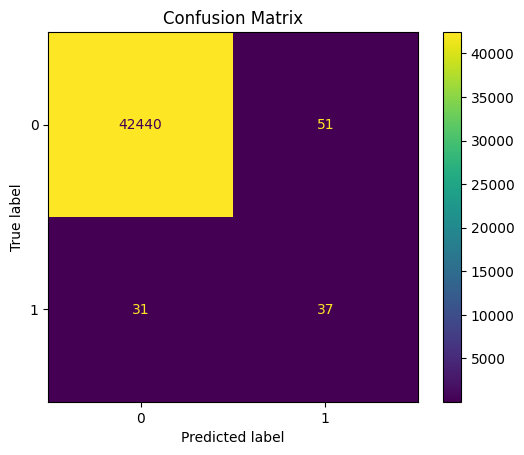

   f1_score  accuracy_score  precision_score  recall_score
0  0.474359        0.998073         0.420455      0.544118


In [30]:
params={'kernel': 'poly', 'nu': 0.002,'gamma':'auto','degree':8}
model=OneClassSVM(**params)
model.fit(xtrain)

ypred=model.predict(xtest)
ypred=inverse_transform_target(ypred)
evaluation(ytest,ypred)

### Histogramme de scores d'anomalies

In [48]:
score=model.score_samples(xtest)
score_pd=pd.Series(score)

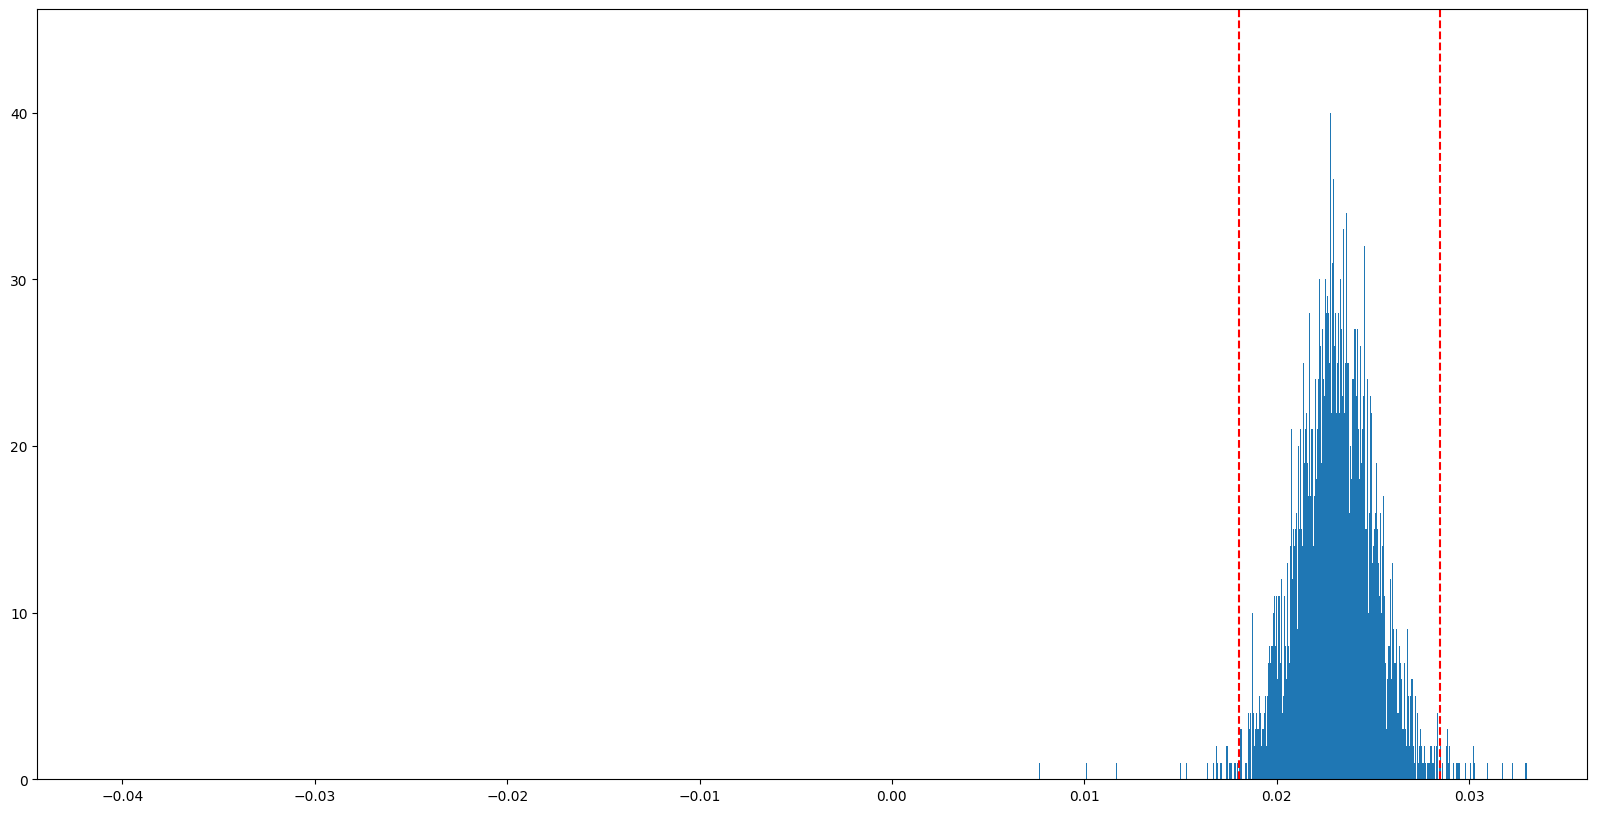

In [49]:
ffig,ax=plt.subplots(figsize=(20,10))
plt.xlim(min(score)-0.05, max(score_pd))
score_pd.hist(bins=10000,grid=False)

# Détermination de pourcentage de contamination
q=99
p=1
plt.axvline(np.percentile(score_pd, q=q), color='red', linestyle='--', label=f'{q}e percentile')
plt.axvline(np.percentile(score_pd, q=p), color='red', linestyle='--', label=f'{p}e percentile')

plt.show()

### Boite à moustache des scores d'anomalies

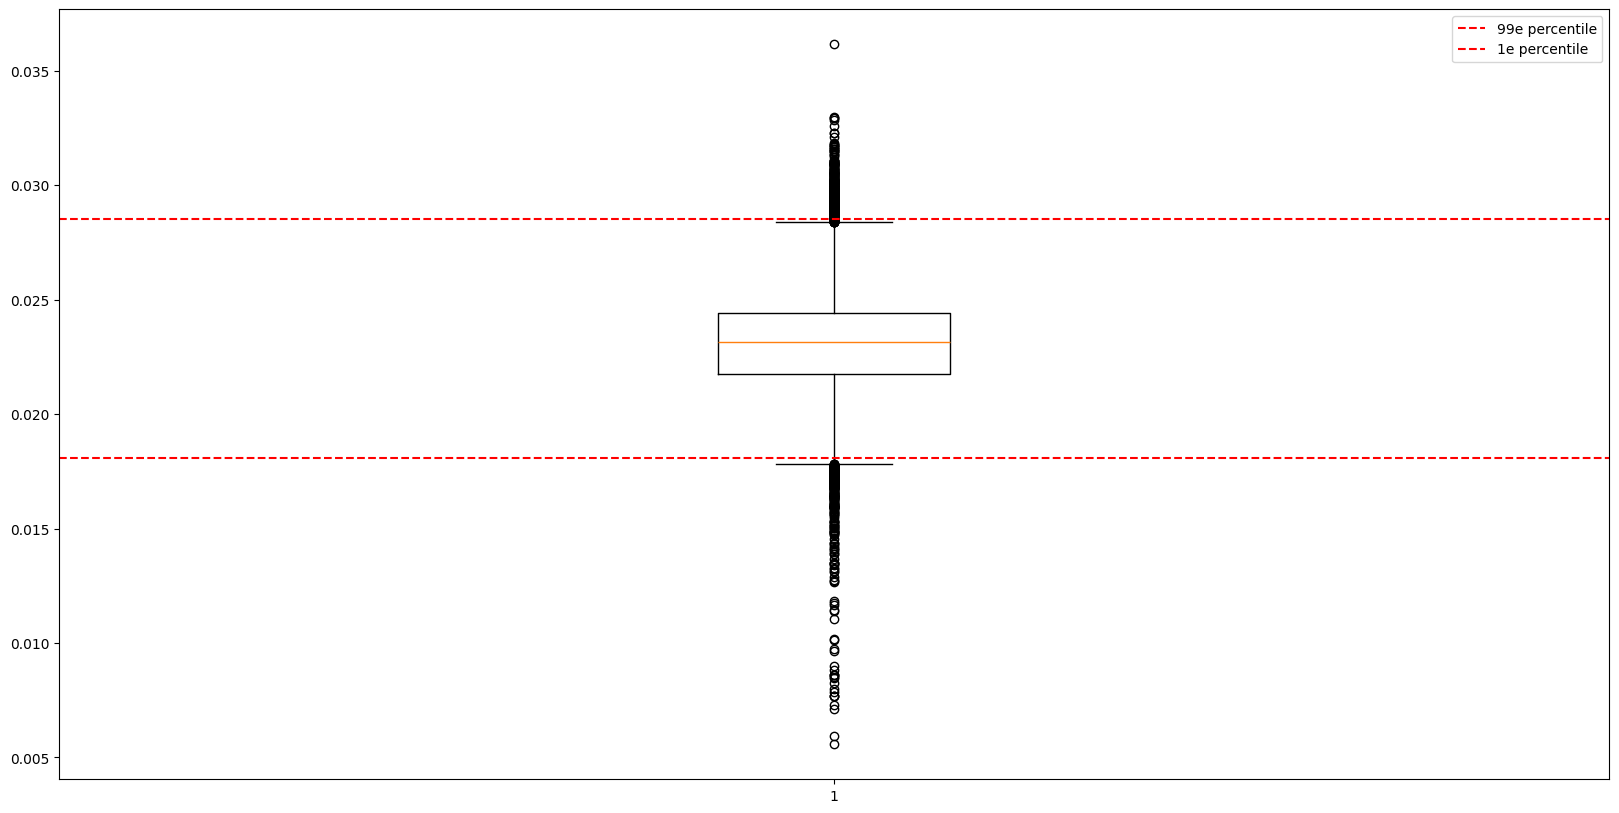

In [37]:
fig,ax=plt.subplots(figsize=(20,10))
# plt.xlim(min(score)-0.2, max(score))
plt.boxplot(score_pd)

# Détermination de pourcentage de contamination
q=99
p=1
plt.axhline(np.percentile(score, q=q), color='red', linestyle='--', label=f'{q}e percentile')
plt.axhline(np.percentile(score, q=p), color='red', linestyle='--', label=f'{p}e percentile')
plt.legend()

plt.show()


### Visualisation des anomalies


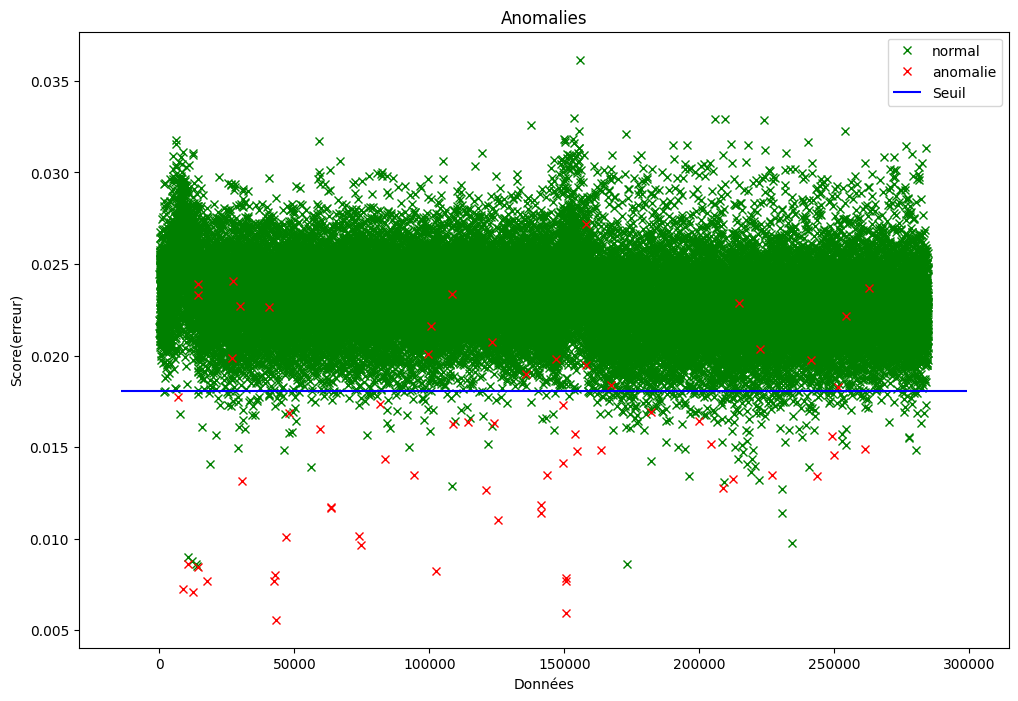

In [42]:
draw_anomaly(y_true=ytest,score=score, seuil=np.percentile(score, q=1))


### Sauvegarde des résulatats

In [43]:
file_name="../resultats/oc_svm.csv"

with open(file_name,"w",newline="") as csvfile:
    writer=csv.DictWriter(csvfile,fieldnames=["y_pred","score_anomalie","y_true"])
    writer.writeheader()
    n=score.shape[0]
    for i in range(n):
        row={
            "y_pred":ypred[i],
            "score_anomalie":score[i],
            "y_true":ytest.iloc[i],
        }
        writer.writerow(row)

### Courbes ROC-AUC

One Class SVM: ROC AUC=0.906


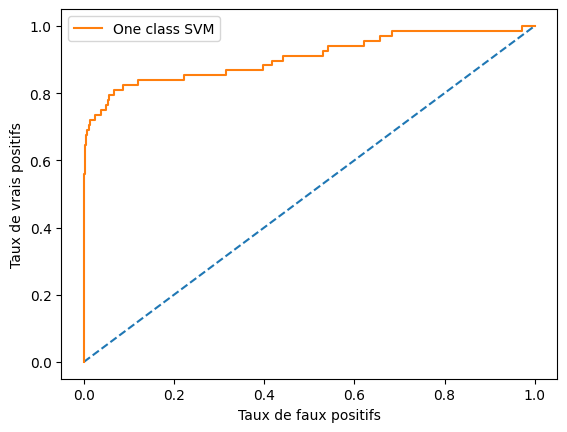

In [52]:

ns_probs = [0 for _ in range(len(ytest))]
# keep probabilities for the positive outcome only
np_score = score.tolist()
#tensor=torch.tensor([np_score])
# lr_probs = torch.softmax(tensor,dim=1,dtype=torch.float32).squeeze(0).numpy()
lr_probs =-model.decision_function(xtest)

# calculate scores
ns_auc = roc_auc_score(ytest, ns_probs)
lr_auc = roc_auc_score(ytest, lr_probs)
# summarize scores

print('One Class SVM: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(ytest, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(ytest, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, linestyle='-', label='One class SVM')
# axis labels
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
# show the legend
plt.legend()
# show the plot
plt.show()

Visualisation TSNE

In [ ]:
df = pd.read_csv('/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/data/creditcard.csv', sep=',')
label = df.iloc[:, -1].copy()
df = df.drop(['Class', 'Time'], axis=1)
df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)

In [ ]:
viz_y = clf.predict(df)
viz_y[viz_y == 1] = 0 # -1 == anomaly, else 1
viz_y[viz_y == -1] = 1

In [ ]:
with open("/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/src/X_embedded_creditcard.pickle", "rb") as file:
    X_embedded = pickle.load(file)

In [ ]:
with open("/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/src/embedded_index_creditcard.pickle", "rb") as file:
    index = pickle.load(file)

Text(0.5, 1.0, 'One Class SVM')

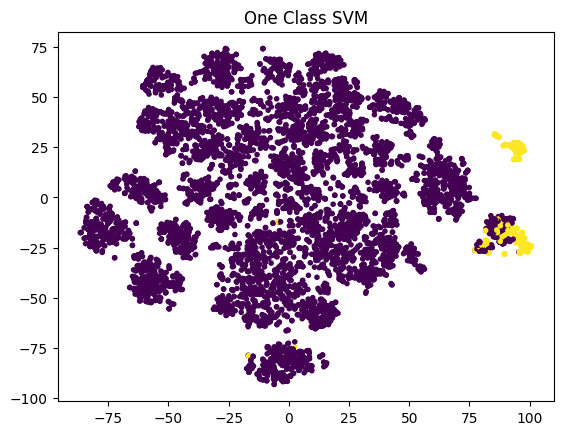

In [ ]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=viz_y[index], marker='.')
plt.title("One Class SVM")

BACKDOOR ANALYSIS

In [ ]:
df = pd.read_csv("/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/data/UNSW_NB15_traintest_backdoor.csv", sep=',')

In [ ]:
label = df['class']
df = df.drop(['class'], axis=1)

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(df, label, test_size=0.15, random_state=42, shuffle=True)

Meilleurs paramètres : {'degree': 3, 'kernel': 'poly', 'nu': 0.0026}
Meilleur score moyen (f1_score) : 0.12218283781342651

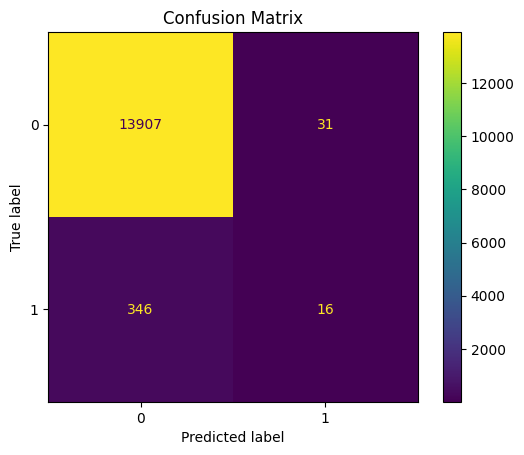

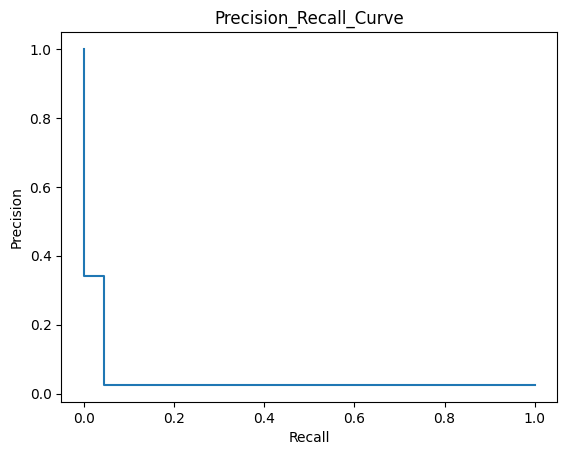

roc_auc 0.5209873797853001


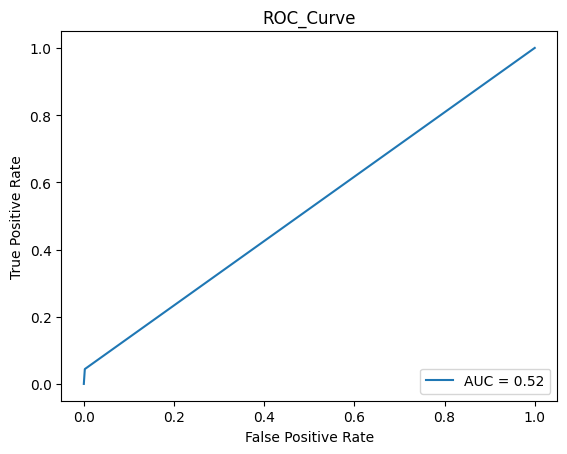

   f1_score  accuracy_score  precision_score  recall_score
0   0.07824        0.973636         0.340426      0.044199


In [ ]:
params_backdoor = {'degree': 3, 'kernel': 'poly', 'nu': 0.0026}
clf_backdoor=OneClassSVM(**params_backdoor)
clf_backdoor.fit(xtrain)

ypred_backdoor=clf_backdoor.predict(xtest)
ypred_backdoor=inverse_transform_target(ypred_backdoor)
evaluation(ytest,ypred_backdoor)

TSNE VISUALISATION BACKDOOR

In [ ]:
viz_y = clf_backdoor.predict(df)
viz_y[viz_y == 1] = 0 # -1 == anomaly, else 1
viz_y[viz_y == -1] = 1

In [ ]:
with open("/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/src/X_embedded_backdoor.pickle", "rb") as file:
    X_embedded = pickle.load(file)

In [ ]:
with open("/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/src/embedded_index_backdoor.pickle", "rb") as file:
    index = pickle.load(file)

Text(0.5, 1.0, 'One Class SVM')

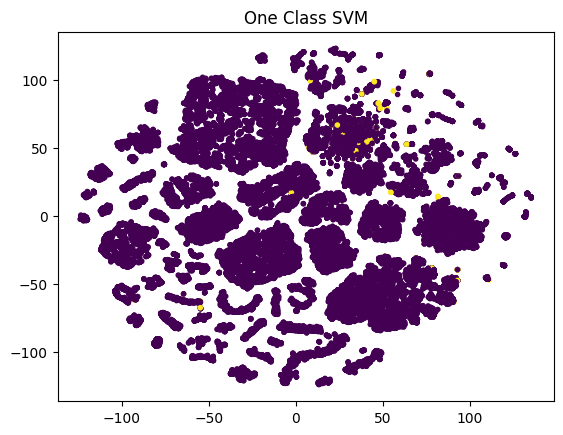

In [ ]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=viz_y[index], marker='.')
plt.title("One Class SVM")